# Pgnet Model with MVN Resampling

Even if you can just get projection plots for a couple of values of n_res that would be great.

Basically what we’re trying to determine is whether the unconstraining transformations in the model are sufficient to get a reasonably well behaved objective function around the mode.  If so, then we can use some of our estimation methods on it.  If not, then maybe pgnet is too complicated to spend what little time we have at this point.

Looking forward to discussing tomorrow.

In [3]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import models
import optax
from functools import partial
import projplot as pjp

import warnings
warnings.filterwarnings('ignore')

In [12]:
key = random.PRNGKey(2)

theta = jnp.log(np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1]))
tau = np.array([1,1,1,1])*1

#x0 = jnp.log(jnp.array([8., 8., 8., 5.]))
theta = np.concatenate([theta, tau])
dt = .1
n_res = 1
n_obs = 100
pgnet_model = models.pgnet_model_log(dt, n_res)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)

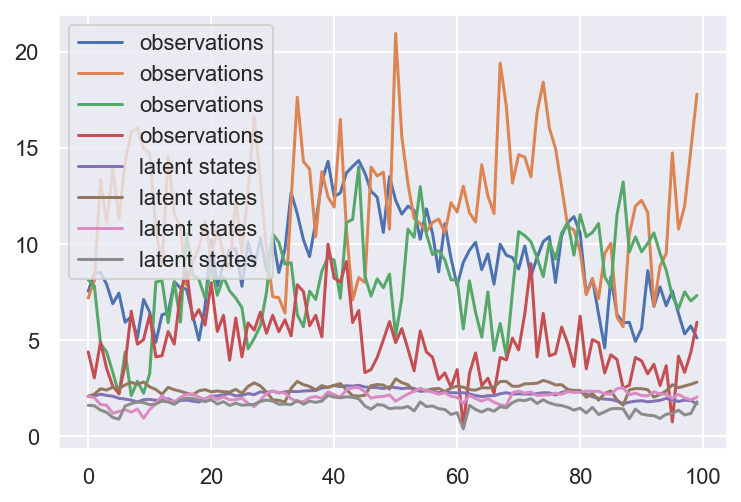

In [13]:
plt.plot(y_meas, label = "observations");
# plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.plot(x_state.squeeze(), label = "latent states")
plt.legend();

In [8]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

In [ ]:
theta_lims = np.array([[0, 0.5], 
                       [0,1], 
                       [0, 0.5],
                       [0, 0.5], 
                       [0, 0.5], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [.1, .5], 
                       [.1, .5], 
                       [.1, .5], 
                       [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [14]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik(theta, model = pgnet_model, resampler = pf.particle_resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        particle_sampler = resampler)
    return -pf.particle_loglik(temp['logw'])

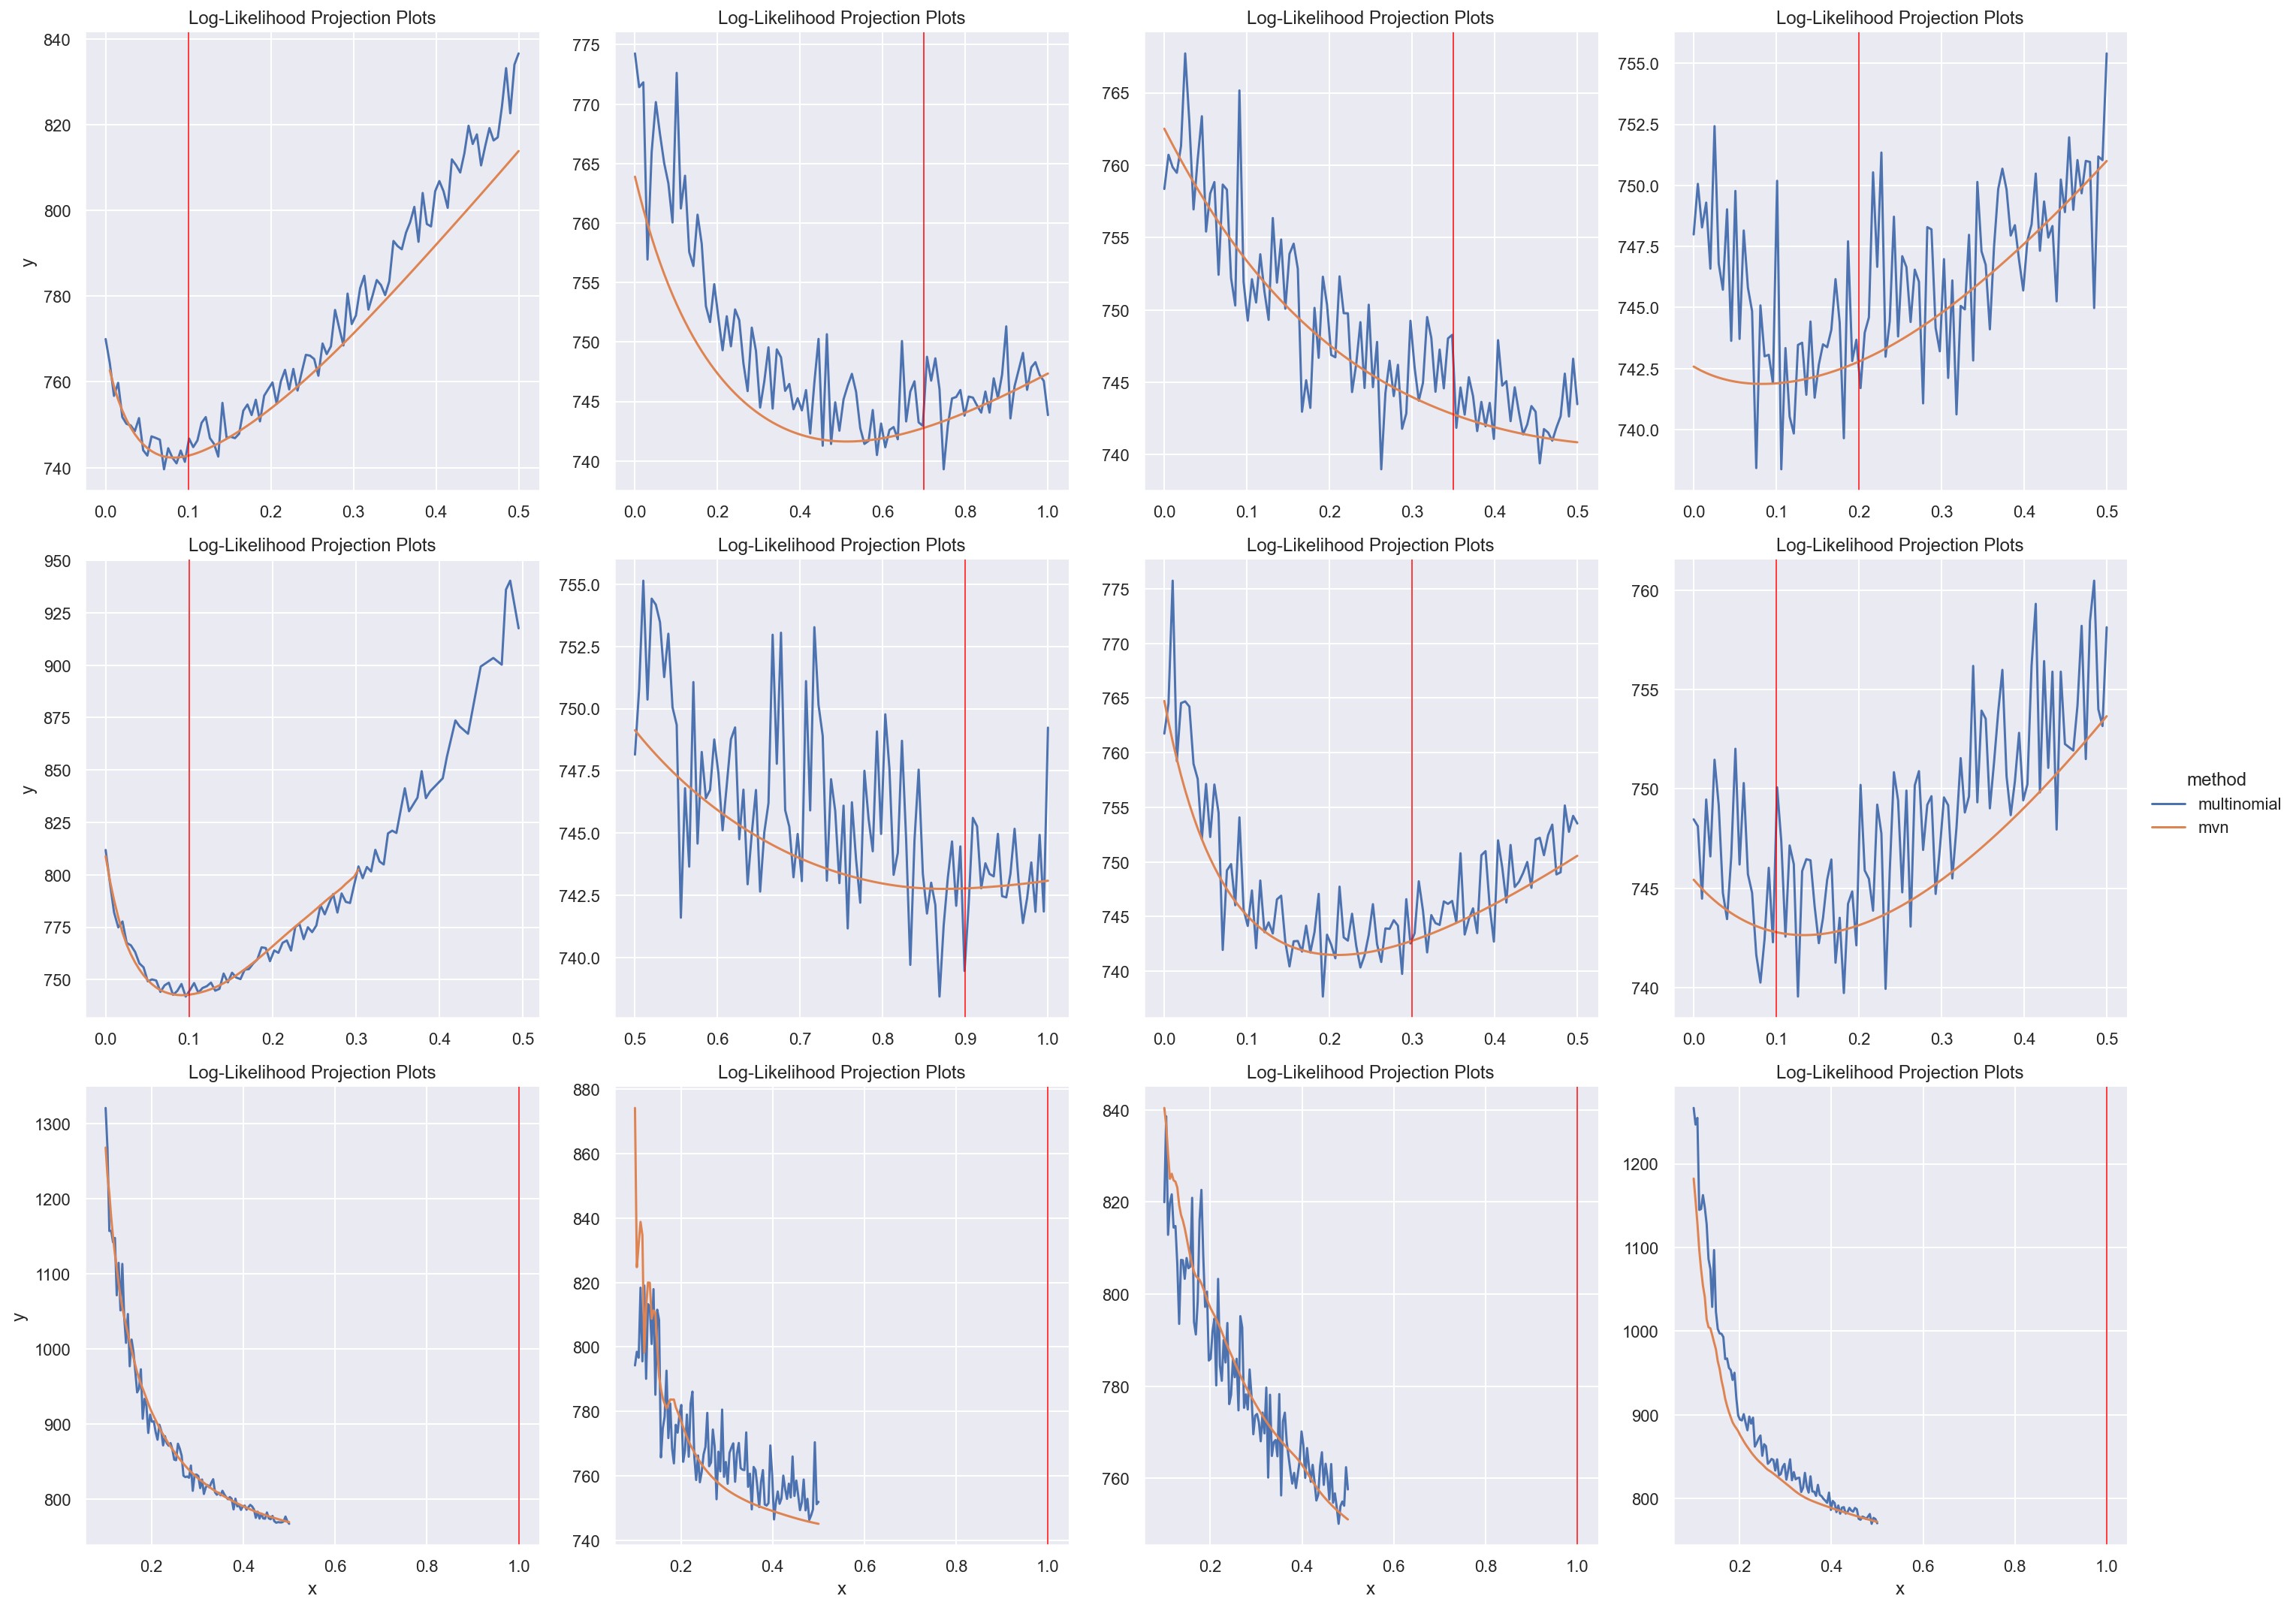

In [16]:
n_particles = 500

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, resampler = pf.particle_resample),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood - Bootstrap Filter")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [17]:
pgnet_bridge = PGNETModel(dt, n_res, bootstrap=False)

In [ ]:
theta_lims = np.array([[-1, 1], 
                       [-1,2], 
                       [0, 0.5],
                       [0, 0.5], 
                       [0, 0.5], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [.1, .5], 
                       [.1, .5], 
                       [.1, .5], 
                       [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [24]:
theta_lims = np.array([[-1, 1]]*12)

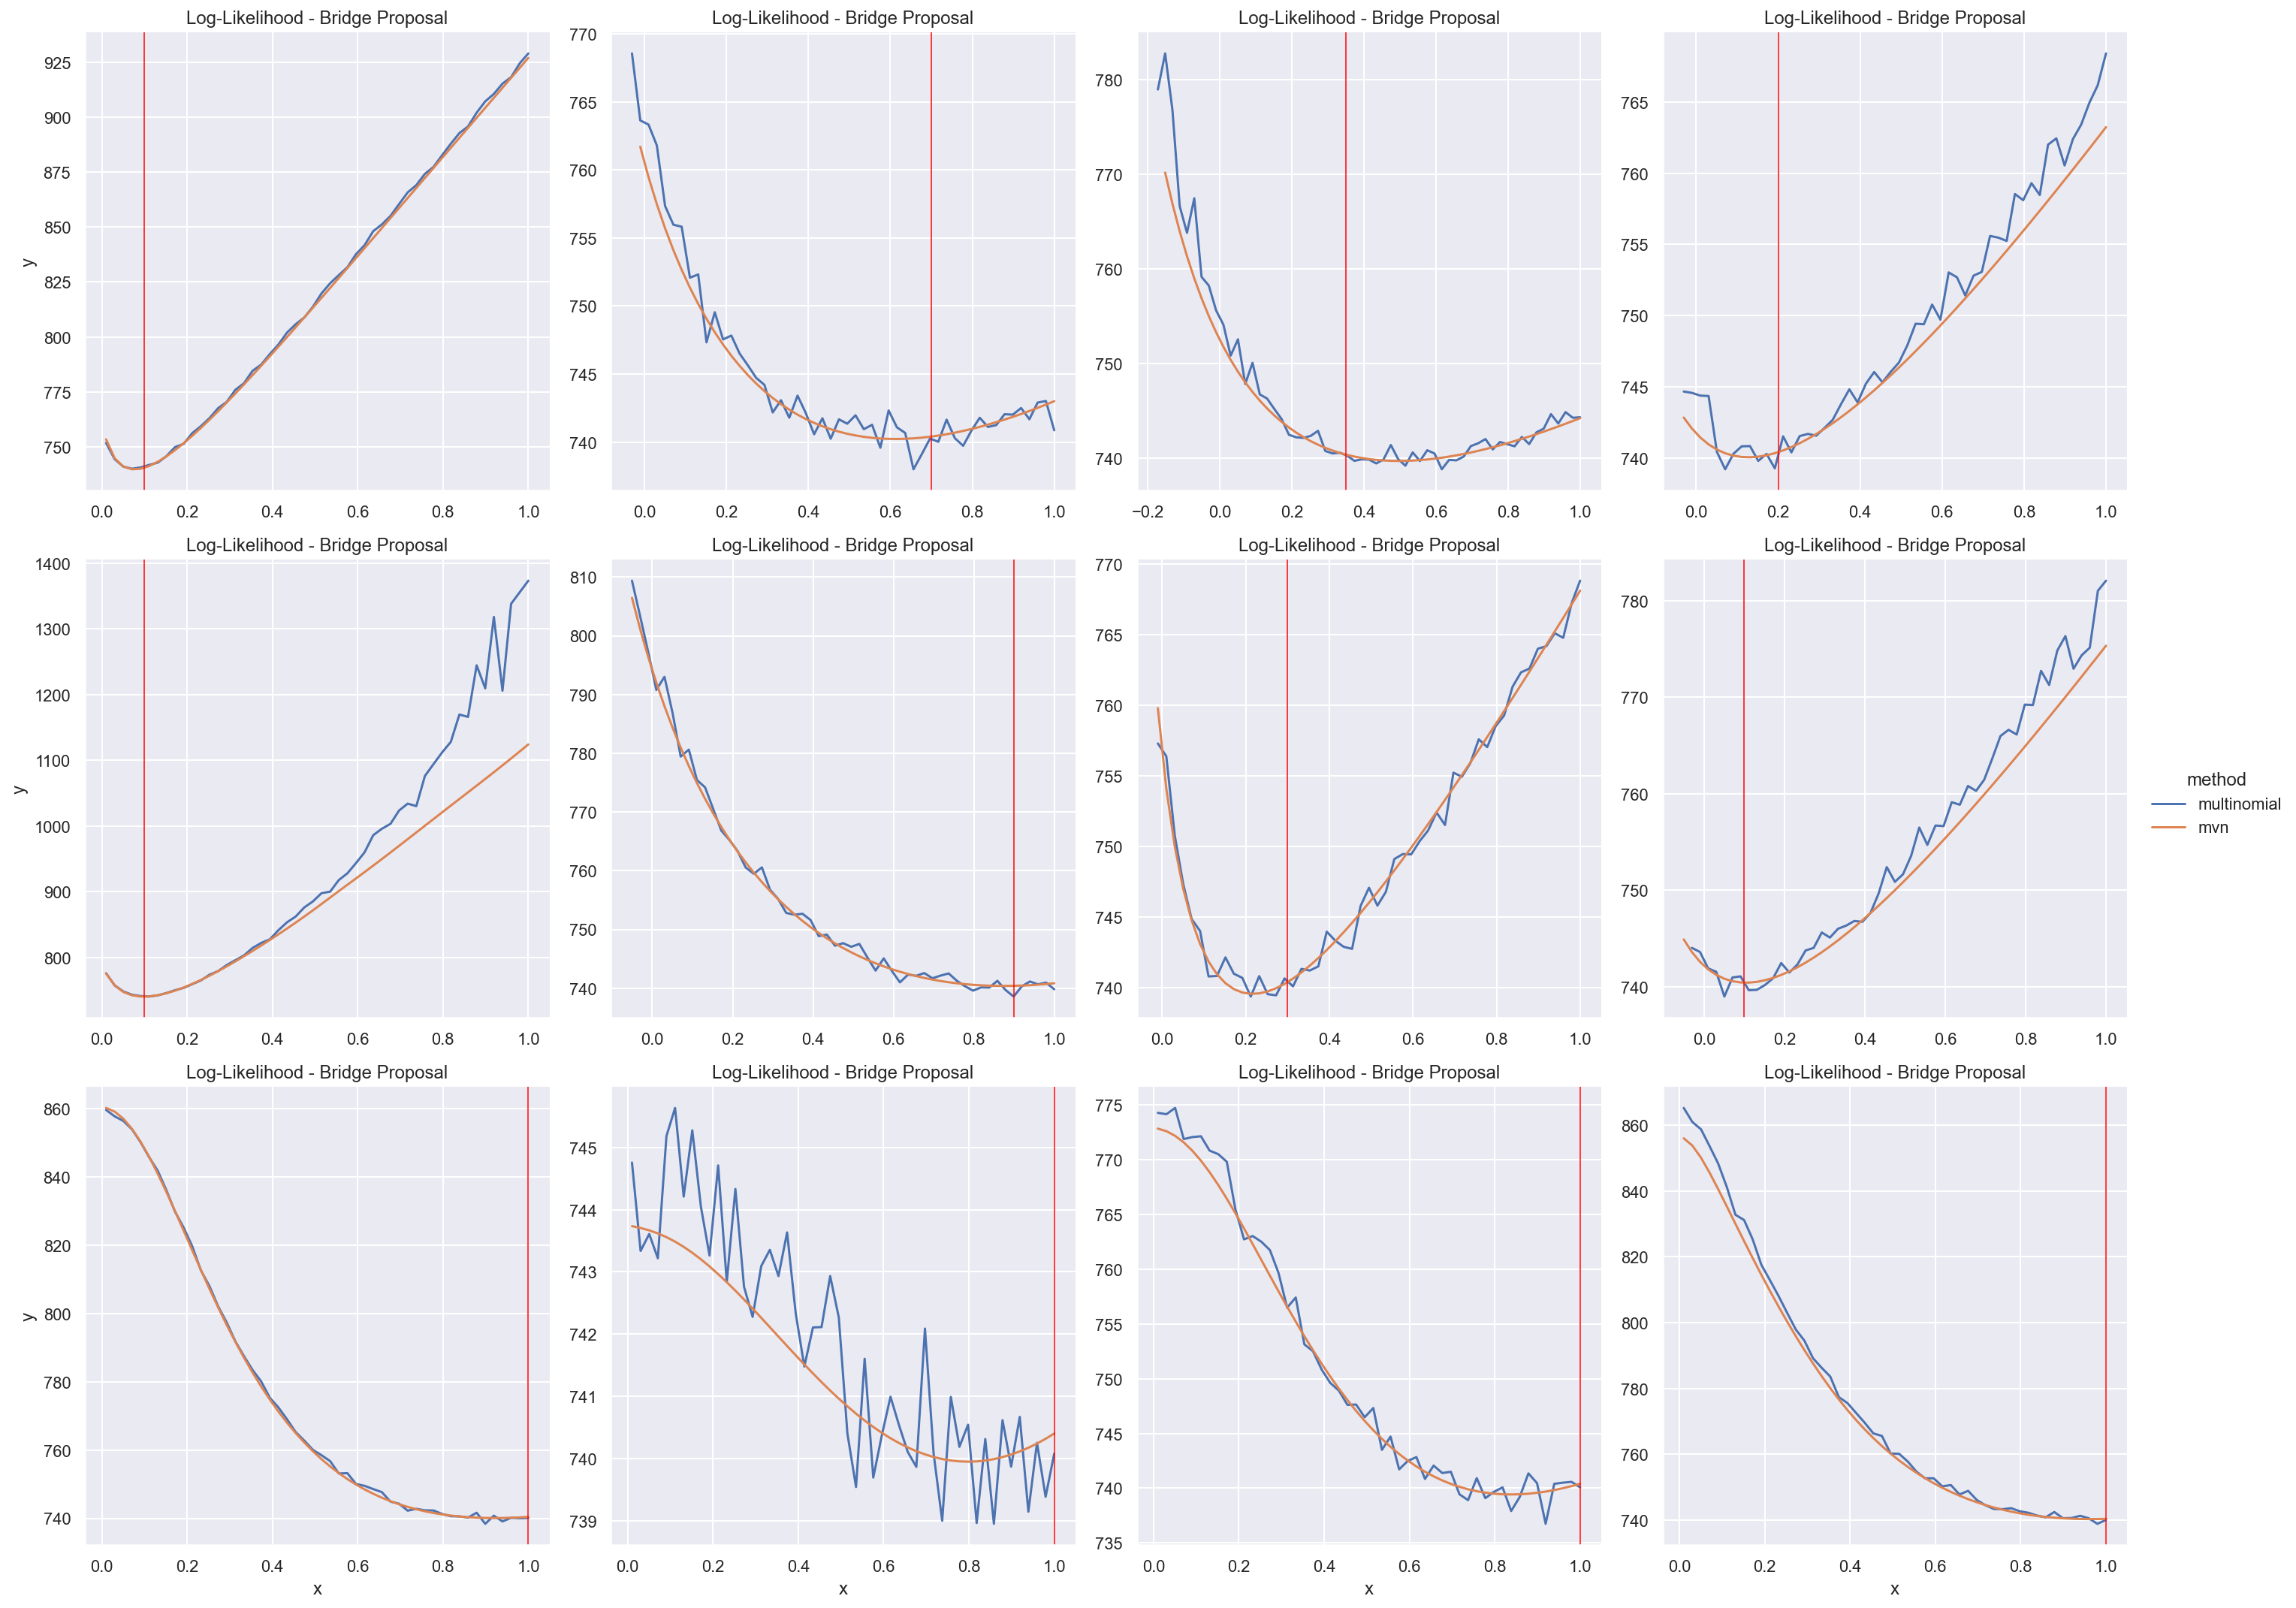

In [25]:
n_particles = 250

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, model = pgnet_bridge), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, model = pgnet_bridge, resampler = pf.particle_resample),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood - Bridge Proposal")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);